SDK Cookbook

Contents:

Easy stuff: look HERE, HERE, and HERE to do XYX

We're going to build up some interactive tools etc using the SDK


2. vessel movements
3. Kplergl product transfers
4. Build custom dashboard (cm heatmap over time) https://medium.com/vis-gl/introducing-kepler-gl-for-jupyter-f72d41659fbf
6. Custom input parameter jupyter notebook (floating storage minimum duration)
7. speed changes over time
8. optimising inefficiencies
9. Distribution of someting ting

- busiest ports clean products last 30 days (count of visits)
- distribution of MR fleet loads, how has this changed in the atlantic basin in last 3 months (east vs west) - what's cheaper on freight. Is it cheaper for me to send gasoline to padd 1 or diesel to europe? (Padd3, padd3  <-> Europe, russian baltic)
- how has distribution of tanker class changed. Asia to Europe, (should see LR2 cannibalised by VLCCs), trend 2018 -> current
- change in voyage time for vessels (strip out FS, diesel/jet heading from asia/middle east to europe, suexmax tankers and below, might see this most pronounced on jet / diesel), (should see tankers taking longer) 2019 - 2020
- number of destination changes for a tanker
- which tankers have done the most/least consistent routes
- flow for which we have good chartere information. Along a given route, who is the most/lest active charterer, where else have they sent that same product to? 
- relationship between vessel owner and charterer
- fleet age, where oldest in world are and where newest tankers in the world (risk of shit going wrong)
- monthly country -> country, three products, monthly or weekly, compare aggregates. (Can benchmark against other things - 3rd party flows data or re

In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline

from datetime import datetime
import warnings

from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vortexasdk as v


warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [3]:
from functools import reduce

def merge(data_frames):
    """Outer merge a list of dataframes on their indexes"""
    return reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="outer"
        ),
        data_frames,
    )

# 1. Find product and geography children

Let's write a few methods to help us manipulate the reference data found in the SDK.

In [14]:
def find_children_ids(all_reference_records, parent_id):
    return [g['id'] for g in all_reference_records if parent in [p['id'] for p in g['parent']]]

In [16]:
all_products = v.Products().load_all()

fuel_oil = v.Products().search("Fuel Oil", exact_term_match=True)[0]['id']

fuel_oil_children = find_children_ids(all_products, fuel_oil)

Loading from API: 2000it [00:00, 3279.17it/s]             


# 2. Create product name dictionary

Let's create a dictionary with product `id`s as dictionary keys, and product names as dictionary values. This will come in useful when we need to switch between product `id`s and product names.

In [60]:
product_id_to_name = {p['id'] : p['name'] for p in v.Products().load_all()}

Loading from API: 2000it [00:00, 2418.26it/s]             


# 3. Plot Floating Storage by product

In [61]:
def load_fs(product_id_to_name, product_id):
    df_fs = v.CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit='b',
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=product_id,
                                     filter_activity="storing_state",
                                     timeseries_activity_time_span_min=1000 * 60 * 60 * 24 * 7,
                                     filter_time_min=datetime(2019, 9, 30),
                                     filter_time_max=datetime(2020, 9, 30)).to_df(columns=['key', 'value'])
    
    product_name = product_id_to_name[product_id]
    col_name = '{} tonnes'.format(product_name)
    
    df_fs = df_fs.rename(columns={'value': col_name})    
    
    # We're not interested in the timestamp here, just the date
    df_fs['date'] = df_fs['key'].dt.date
    
    return df_fs.set_index('date')[col_name]

In [62]:
df = merge([load_fs(product_id_to_name, child) for child in fuel_oil_children])

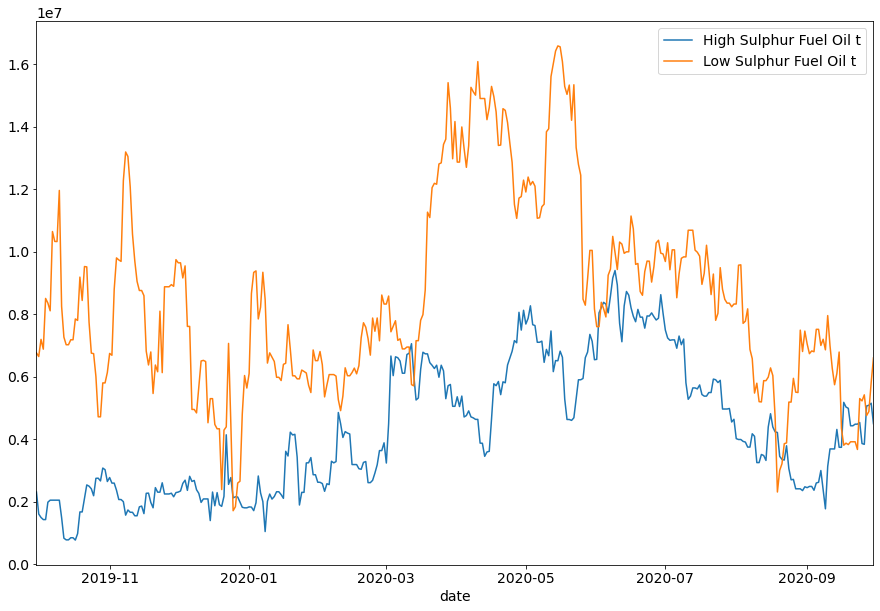

In [65]:
df.plot();

# 4. Interactive Custom Floating Storage trends

topics covered:
floating storage
interactive notebooks
timeseries

Here we use the CargoTimeSeries SDK endpoint and Jupyter Notebook's interactive plotting features to explore global .

Let's see how the total tonnage of Crude in floating storage globally has varied over the last year. The definition of floating storage is a fluid one, does a vessel standing stationary for 7 days count as floating storage, or is 14 days required? The SDK lets us specify the minimum days required for a cargo to be included in floating storage aggregates, we'll take advantage of that parameter here.

First we use the Products endpoint to find the id of Crude/Condensates

Then, we search the CargoTimeSeries endpoint, finding the total global tonnage in floating storage each day over the last 3 years. The minimum-days-required-for-a-stationary-vessel-to-count-as-floating-storage parameter (we'll call this `min_days` from now on), we'll consider `7, 10, 13, ... 31` days, given by python's range function, `range(7, 32, 3)`.

Merging these dataframes allows us to interactively plot each column.

In [88]:
crude_and_condensates = v.Products().search('Crude/Condensates', exact_term_match=True)[0]["id"]

def convert_days_to_ms(n_days):
    return 1000 * 60 * 60 * 24 * n_days

def fetch_global_crude_floating_storage_timeseries(n_days_storage_minimum):
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = v.CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit='t',
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     timeseries_activity_time_span_min=convert_days_to_ms(n_days_storage_minimum),
                                     filter_time_min=datetime(2019, 1, 1),
                                     filter_time_max=datetime(2020, 9, 30)).to_df(columns=['key', 'value'])
    
    # convert to kt
    df_fs['value'] = df_fs['value'] / 1000
    
    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': 'min{}d kt'.format(n_days_storage_minimum)
                                 })
    
    # We're not interested in the timestamp here, just the date
    df_fs['date'] = df_fs['date'].dt.date
    
    return df_fs.set_index('date')

In [89]:
dfs = [fetch_global_crude_floating_storage_timeseries(d) for d in range(7, 32, 3)]
df = merge(dfs)

In [90]:
def plot_figure(min_days):
    plt.figure(2)
    x = df.index
    y_col = 'min{}d kt'.format(min_days)
    y = df[y_col]
    df[y_col].plot(ylim=(0, df.max().max()))
    
    plt.xlabel('date')
    plt.ylabel('kt');
    plt.title('Crude global floating storage, of minimum duration {} days'.format(min_days))

In [91]:
interactive_plot = interactive(plot_figure, min_days=(7, 32, 3))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=19, description='min_days', max=32, min=7, step=3), Output()), _dom_clas…

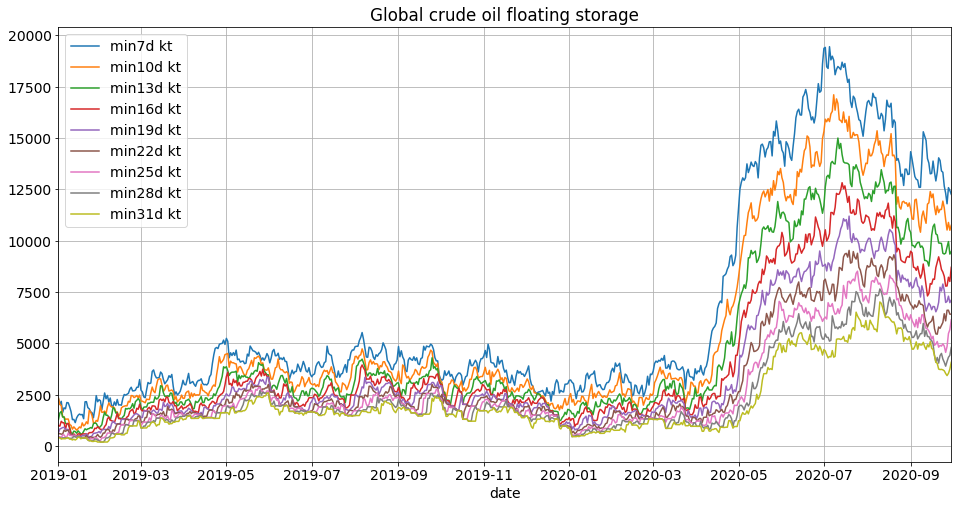

In [92]:
df.plot(title='Global crude oil floating storage', grid=True, figsize=(16, 8));

So short term fs has vastly increased, though it's difficult to see the percentage increases from this chart. Let's scale each floating storage aggregate with respect to its 2019 levels to see the percentage increase on 2019.

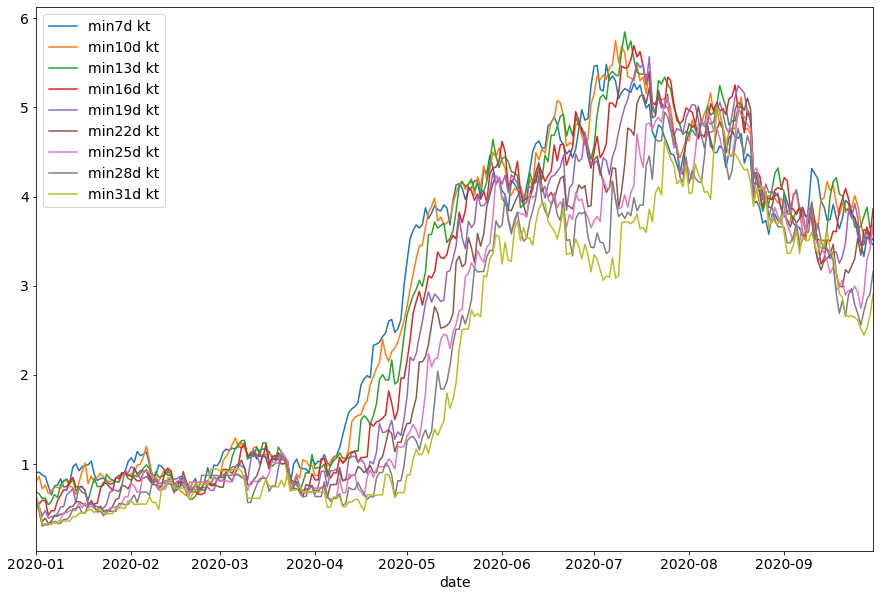

In [119]:
df_2020 = df[df.index >= datetime(2020, 1, 1).date()]
df_2019 = df[df.index < datetime(2020, 1, 1).date()]

# For each n_days_storage_medium, we calculate the mean kt in floating storage during 2019
mean_2019 = df_2019.mean()

(df_2020 / mean_2019).plot()


# 5. What are the busiest Clean import ports?

In [5]:
# First we find the id for clean petroleum products
clean_id = v.Products().search("Clean Petroleum Products", exact_term_match=True)[0]['id']

In [8]:
# Now let's find all vessel movements loading the clean products 

def load_clean_import_count_month(month):
    # Load all clean vessel movements discharging in our chosen month
    vms = v.VesselMovements().search(filter_activity='unloading_start',
                               filter_time_min=datetime(2020, month, 1),
                               filter_time_max=datetime(2020, month + 1, 1),
                               filter_products=clean_id
                              ).to_df()
    # Count the number of vessels, then rename and transpose
    return pd.DataFrame(vms['destination.location.port.label'].value_counts())\
        .rename(columns={'destination.location.port.label': datetime(2020, month, 1)})\
        .transpose()
    

In [9]:
counts_per_month = pd.concat([load_clean_import_count_month(month) for month in [7, 8, 9]])

Loading from API: 18000it [00:18, 992.05it/s]                            
Loading from API: 17500it [00:19, 916.58it/s]                            
Loading from API: 17500it [00:18, 944.71it/s]                            


In [19]:
busiest_ports = counts_per_month.sum().sort_values().tail(5).index

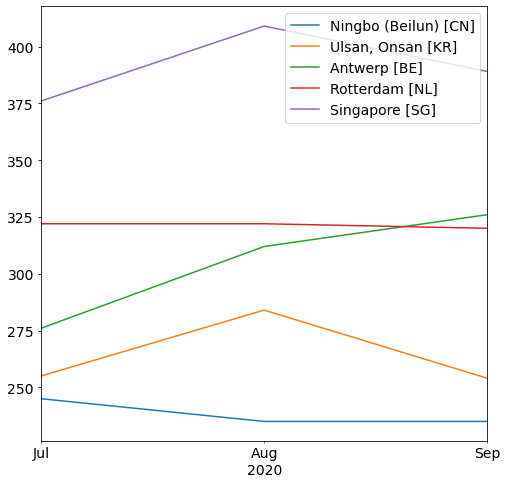

In [22]:
counts_per_month[busiest_ports].plot(figsize=(8, 8))

# 6. MF Fleet distribution either side of Atlantic basin

Let's see the proportion of MR2s

# 7. Change in Voyage time for Jey heading from Asia to Europe for suexmax tankers

In [24]:
asia = v.Geographies().search('Asia', exact_term_match=True)[0]['id']
europe = v.Geographies().search('Europe', exact_term_match=True)[0]['id']

In [48]:
vms = v.VesselMovements().search(filter_activity='unloading_start',
                           filter_time_min=datetime(2020, 1, 1),
                           filter_time_max=datetime(2020, 10, 1),
                           filter_origins=asia,
                           filter_destinations=europe,      
                           filter_vessel_classes=['suezmax']
                          ).to_df('all')

In [61]:
# Remove movements without timestamps, and calculate journey length
vms = vms[(vms['destination.start_timestamp'].notna()) & (vms['origin.end_timestamp'].notna())]
vms['journey_days'] = (vms['destination.start_timestamp'] - vms['origin.end_timestamp']) / np.timedelta64(1, 'D')
vms['journey_start_month'] = vms['origin.end_timestamp'].dt.month

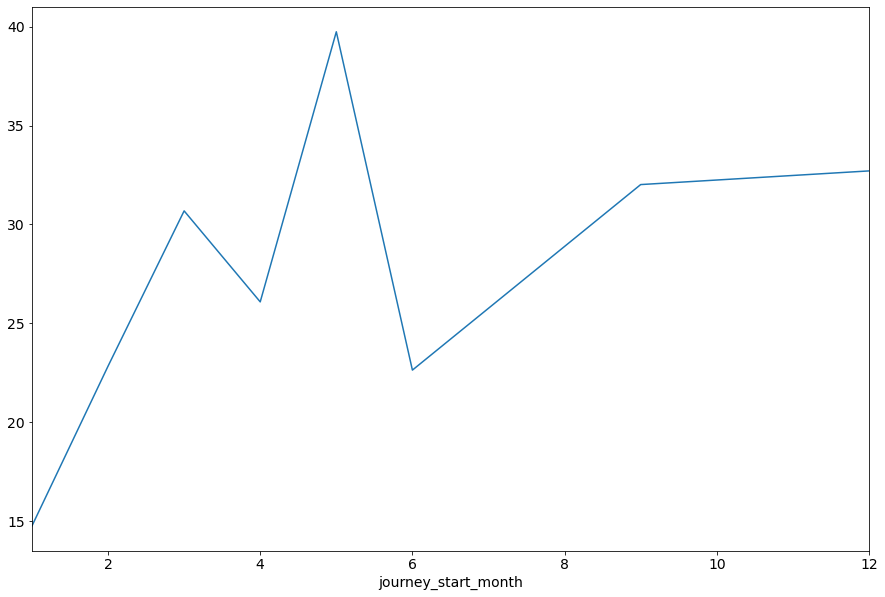

In [60]:
vms.groupby(by='journey_start_month')['journey_days'].mean().plot();

# 8. Route consistency by tanker

In [32]:
search_result = v.VesselMovements().search(filter_activity='unloading_start',
                           filter_time_min=datetime(2020, 1, 1),
                           filter_time_max=datetime(2020, 10, 12),
                          )
vms = search_result.to_df(['vessel.imo', 'origin.location.port.label', 'destination.location.port.label'])

Loading from API: 298500it [07:14, 686.87it/s]                             


In [35]:
# Find all vessels that have been on more than 10 journeys

vessel_to_count_of_movements = vms['vessel.imo'].value_counts()
vessel_has_sufficient_movements = vessel_to_count_of_movements > 2

vessels_with_sufficient_journeys = vessel_to_count_of_movements[vessel_has_sufficient_movements].index

In [36]:
vms = vms[vms['vessel.imo'].isin(vessels_with_sufficient_journeys)]
vms = vms[(vms['origin.location.port.label'].notnull()) & (vms['destination.location.port.label'].notnull())]

In [39]:
vms['route'] = vms['origin.location.port.label'] + ' -> ' + vms['destination.location.port.label']

In [42]:
unique_route_count = vms.groupby('vessel.imo')['route'].nunique()

In [43]:
all_routes_count = vms.groupby('vessel.imo')['route'].count()

In [44]:
unique_route_count

vessel.imo
2336059.0     5
4521997.0    15
6720004.0     1
6806444.0    24
6903981.0    11
             ..
9887047.0     7
9890185.0    58
9890549.0     2
9892262.0    10
9896919.0    14
Name: route, Length: 9762, dtype: int64

In [56]:
all_routes_count_df = pd.DataFrame(all_routes_count).rename(columns={'route': 'all routes count'})
unique_route_count_df = pd.DataFrame(unique_route_count).rename(columns={'route': 'unique routes count'})

In [57]:
unique_route_count_df

,unique routes count
vessel.imo,
2336059.0,5
4521997.0,15
6720004.0,1
6806444.0,24
6903981.0,11
...,...
9887047.0,7
9890185.0,58
9890549.0,2


In [67]:
route_counts = pd.concat([all_routes_count_df, unique_route_count_df], axis=1)

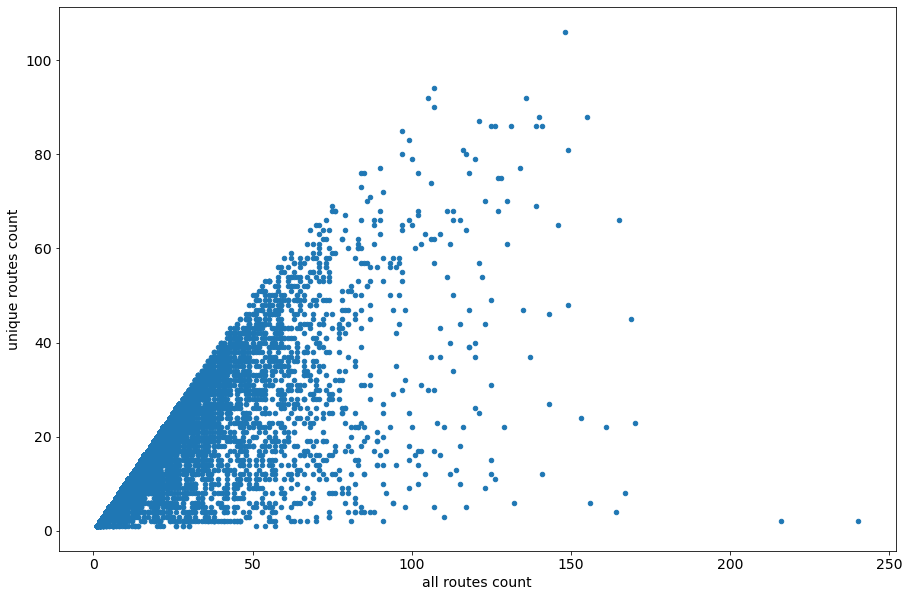

In [68]:
route_counts.plot(x='all routes count', y='unique routes count', kind='scatter');

In [69]:
route_counts['proportion unique'] = route_counts['unique routes count'] / route_counts['all routes count']

In [71]:
route_counts[route_counts['all routes count'] > 75].sort_values('proportion unique').tail()

,all routes count,unique routes count,proportion unique
vessel.imo,,,
9410519.0,107,94,0.878505
9320063.0,85,76,0.894118
9425356.0,76,68,0.894737
9391000.0,76,68,0.894737
9191656.0,84,76,0.904762


In [72]:
vms[vms['vessel.imo'] == 9191656.0]

,vessel.imo,origin.location.port.label,destination.location.port.label,route
194492,9191656.0,Stade [DE],Antwerp [BE],Stade [DE] -> Antwerp [BE]
194493,9191656.0,"Brunsbuttel, SH [DE]",Bilbao [ES],"Brunsbuttel, SH [DE] -> Bilbao [ES]"
194494,9191656.0,Rotterdam [NL],Port Jerome [FR],Rotterdam [NL] -> Port Jerome [FR]
194495,9191656.0,Port Jerome [FR],Rotterdam [NL],Port Jerome [FR] -> Rotterdam [NL]
194496,9191656.0,Rotterdam [NL],Stade [DE],Rotterdam [NL] -> Stade [DE]
...,...,...,...,...
269987,9191656.0,Terneuzen [NL],Antwerp [BE],Terneuzen [NL] -> Antwerp [BE]
269988,9191656.0,Antwerp [BE],Ruisbroek [BE],Antwerp [BE] -> Ruisbroek [BE]
269989,9191656.0,Immingham [GB],Immingham [GB],Immingham [GB] -> Immingham [GB]
269990,9191656.0,Gavle X [SE],Kotka [FI],Gavle X [SE] -> Kotka [FI]


# 9. World heatmap of fleet age

In [4]:
vms = v.VesselMovements().search(filter_activity='unloading_start',
                           filter_time_min=datetime(2020, 1, 1),
                           filter_time_max=datetime(2020, 3, 1),     
                           filter_vessel_classes=['suezmax']
                          ).to_df('all')

Loading from API: 3000it [00:02, 1208.41it/s]             


In [5]:
# Only interested in the last movement per vessel
last_movements = vms.sort_values(by='end_timestamp', ascending=True)\
    .drop_duplicates(subset=['vessel.id'], keep='last')

In [6]:
last_movements['vessel_age'] = 2020 - last_movements['vessel.year']

age_coords = last_movements[['vessel_age', 'destination.pos.0', 'destination.pos.1']]

In [9]:
from keplergl import KeplerGl
map_1 = KeplerGl()
map_1.add_data(data=age_coords)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [13]:
map_1

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '4qoyaei', 'type': …